In [1]:
import numpy as np
import pandas as pd

In [2]:
from pandas.tseries.offsets import Day, Week

In [3]:
stores = pd.read_parquet('/main/data/MVideo_2/stores.parquet')

In [4]:
nostores = pd.read_parquet('/main/data/MVideo_2/nostores.parquet')

In [5]:
st = np.setdiff1d(stores.Store_ID.values, nostores.Store_ID.values)

In [6]:
products = pd.read_parquet('/main/data/MVideo_2/skus.parquet')

In [7]:
noproducts = pd.read_parquet('/main/data/MVideo_2/noskus.parquet')

In [8]:
pr = np.setdiff1d(products.Product_ID.values, noproducts.Product_ID.values)

In [9]:
trans = pd.read_parquet('/main/data/MVideo_2/dailysales.parquet')

In [10]:
trans1 = trans[
    (trans.STORE_ID.isin(st)) &
    (trans.PRODUCT_ID.isin(pr))
].copy()

In [11]:
trans1['PROMOTION'] = trans1.PROMOTION_ID != 0

In [12]:
trans1['UNITS_SOLD_NP'] = trans1.UNITS_SOLD * (1 - trans1.PROMOTION)

In [13]:
trans1['UNITS_SOLD_P'] = trans1.UNITS_SOLD * trans1.PROMOTION

In [14]:
trans1['REVENUE_INCL_TAX_NP'] = trans1.REVENUE_INCL_TAX * (1 - trans1.PROMOTION)

In [15]:
trans1['REVENUE_INCL_TAX_P'] = trans1.REVENUE_INCL_TAX * trans1.PROMOTION

In [16]:
trans1.drop(columns = ['PROMOTION_ID', 'PROMOTION'], inplace = True)

In [17]:
prods = pd.read_parquet('/main/data/MVideo_2/products.parquet')

In [18]:
prods1 = prods[['PRODUCT_ID', 'SUBCATEGORY_ID']].copy()

Последние 3 цифры однозначно определяют подкатегорию

In [19]:
prods1.SUBCATEGORY_ID = prods1.SUBCATEGORY_ID.astype('str').str[-3:].astype('int')

In [20]:
trans2 = trans1.merge(prods1, on = ['PRODUCT_ID'])

In [21]:
trans2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1273748 entries, 0 to 1273747
Data columns (total 10 columns):
STORE_ID               1273748 non-null object
PRODUCT_ID             1273748 non-null int64
DATE                   1273748 non-null datetime64[ns]
UNITS_SOLD             1273748 non-null int64
REVENUE_INCL_TAX       1273748 non-null float64
UNITS_SOLD_NP          1273748 non-null int64
UNITS_SOLD_P           1273748 non-null int64
REVENUE_INCL_TAX_NP    1273748 non-null float64
REVENUE_INCL_TAX_P     1273748 non-null float64
SUBCATEGORY_ID         1273748 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(5), object(1)
memory usage: 106.9+ MB


In [22]:
trans2.to_parquet('/main/data/MVideo_2/transactions_ft_5.parquet')

In [23]:
week = trans2[['DATE', 'STORE_ID', 'PRODUCT_ID']]

In [24]:
del trans, trans1, trans2

In [25]:
week1 = week.copy()

In [26]:
week1.DATE = week1.DATE.where(week1.DATE == ((week1.DATE + Week(weekday=6)) - Week()), week1.DATE + Week(weekday=6))

In [27]:
week1.drop_duplicates(inplace = True)

In [28]:
week1.shape

(801526, 3)

In [29]:
week1min = week1.groupby(['STORE_ID', 'PRODUCT_ID'])[['DATE']].min().reset_index()

In [30]:
week1max = week1.groupby(['STORE_ID', 'PRODUCT_ID'])[['DATE']].max().reset_index()

In [31]:
weekrange = pd.merge(week1min, week1max, on = ['STORE_ID', 'PRODUCT_ID'])

In [32]:
weekrange.rename(columns = {'DATE_x': 'DATE_MIN', 'DATE_y': 'DATE_MAX'}, inplace = True)

Заполняем хвосты вправо в тесте

In [33]:
weekrange.DATE_MAX = weekrange.DATE_MAX.where(weekrange.DATE_MAX < '2018-05-20', pd.Timestamp('2018-07-08'))

In [34]:
#weekrange.DATE_MIN += Week(12)

In [35]:
week2 = pd.merge(weekrange[['STORE_ID', 'PRODUCT_ID']].assign(key = 0),
                 pd.DataFrame({'DATE': pd.date_range(start = weekrange.DATE_MIN.min(),
                                                     end = weekrange.DATE_MAX.max(),
                                                     freq = '7D')}).assign(key = 0),
                 on = 'key').drop('key', axis = 1)

In [36]:
week2.shape

(12218514, 3)

In [37]:
week3 = week2.merge(weekrange, how = 'left', on = ['STORE_ID', 'PRODUCT_ID'])

In [38]:
week4 = week3[
    (week3.DATE >= week3.DATE_MIN) &
    (week3.DATE <= week3.DATE_MAX)
].copy()

In [39]:
week4.drop(columns = ['DATE_MIN', 'DATE_MAX'], inplace = True)

In [40]:
week4.shape

(2943769, 3)

In [41]:
#week4.to_parquet('/main/data/MVideo_2/transactions_ft_5_1.parquet')

In [42]:
week4.DATE -= Day(7)

In [43]:
week4 = week4[(week4.DATE > '2016-07-03')]

In [44]:
week4[week4.DATE < '2018-05-13'].shape

(2707492, 3)

In [45]:
week4[week4.DATE >= '2018-05-13'].shape

(228237, 3)

In [46]:
week4.groupby(['STORE_ID', 'PRODUCT_ID']).count().DATE.hist(bins = 105)

In [47]:
prods2 = prods[['PRODUCT_ID', 'MAINCATEGORY_ID', 'SUBCATEGORY_ID']].copy()

In [48]:
prods2.SUBCATEGORY_ID = prods2.SUBCATEGORY_ID.astype('str').str[-3:].astype('int')

In [49]:
week5 = week4.merge(prods2, on = ['PRODUCT_ID'])

In [50]:
week5

,STORE_ID,PRODUCT_ID,DATE,MAINCATEGORY_ID,SUBCATEGORY_ID
0,S011,10007755,2016-08-14,107,302
1,S011,10007755,2016-08-21,107,302
2,S011,10007755,2016-08-28,107,302
3,S011,10007755,2016-09-04,107,302
4,S011,10007755,2016-09-11,107,302
5,S011,10007755,2016-09-18,107,302
6,S011,10007755,2016-09-25,107,302
7,S011,10007755,2016-10-02,107,302
8,S011,10007755,2016-10-09,107,302
9,S011,10007755,2016-10-16,107,302


In [51]:
prodlocs = pd.read_parquet('/main/data/MVideo_2/productlocations.parquet')

In [52]:
prodlocs1 = prodlocs[['STORE_ID', 'PRODUCT_ID', 'REGULAR_SALES_PRICE_INCL_TAX']]

In [53]:
week6 = week5.merge(prodlocs1, on = ['STORE_ID', 'PRODUCT_ID'])

In [54]:
locs = pd.read_parquet('/main/data/MVideo_2/locations.parquet')

In [55]:
locs1 = locs[locs.STORE_ID.isin(st)][['STORE_ID', 'REGION', 'STORETYPE']].copy()

In [56]:
locs1.rename(columns = {'STORETYPE': 'INTERNET'}, inplace = True)

In [57]:
locs1.REGION = locs1.REGION.map({'MV_Московский Дивизион': 77, 'MV_Сибирский Дивизион': 54})

In [58]:
locs1.INTERNET = locs1.INTERNET.map({'Магазин': 0, 'Интернет магазин': 1})

In [59]:
week7 = week6.merge(locs1, on = ['STORE_ID'])

In [60]:
week7.shape

(2935729, 8)

In [61]:
week7.isnull().sum().sum()

0

In [62]:
week7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935729 entries, 0 to 2935728
Data columns (total 8 columns):
STORE_ID                        object
PRODUCT_ID                      int64
DATE                            datetime64[ns]
MAINCATEGORY_ID                 int64
SUBCATEGORY_ID                  int64
REGULAR_SALES_PRICE_INCL_TAX    int64
REGION                          int64
INTERNET                        int64
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 201.6+ MB


In [63]:
del week1, week2, week3, week4, week5, week6

In [64]:
promos = pd.read_parquet('/main/data/MVideo_2/promotions.parquet')

In [65]:
promos1 = promos[
    (promos.STORE_ID.isin(st)) &
    (promos.PRODUCT_ID.isin(pr))
].reset_index(drop = True).copy()

In [66]:
promos1.drop(columns = ['PROMOTION_ID', 'PROMOTION_DESCRIPTION'], inplace = True)

In [67]:
promos1.PROMOTION_FROMDATE.where(promos1.PROMOTION_FROMDATE == ((promos1.PROMOTION_FROMDATE + Week(weekday=6)) - Week()),
                                 promos1.PROMOTION_FROMDATE + Week(weekday=6),
                                 inplace = True)

In [68]:
promos1.PROMOTION_TODATE.where(promos1.PROMOTION_TODATE == ((promos1.PROMOTION_TODATE + Week(weekday=6)) - Week()),
                               promos1.PROMOTION_TODATE + Week(weekday=6),
                               inplace = True)

In [69]:
promos1.head()

,PROMOTION_FROMDATE,PROMOTION_TODATE,STORE_ID,PRODUCT_ID
0,2016-07-03,2016-07-03,S280,20031605
1,2016-07-31,2016-07-31,S306,10007828
2,2016-10-09,2016-10-09,S280,10010108
3,2016-11-20,2016-11-20,S459,10010261
4,2016-11-27,2016-11-27,S223,10010514


In [70]:
promos2 = pd.merge(promos1[['STORE_ID', 'PRODUCT_ID']].assign(key = 0),
                 pd.DataFrame({'DATE': pd.date_range(start = promos1.PROMOTION_FROMDATE.min(),
                                                     end = promos1.PROMOTION_TODATE.max(),
                                                     freq = '7D')}).assign(key = 0),
                 on = 'key').drop('key', axis = 1)

In [71]:
promos3 = promos2.merge(promos1, how = 'left', on = ['STORE_ID', 'PRODUCT_ID'])

In [72]:
del promos1, promos2

In [73]:
promos3.head()

,STORE_ID,PRODUCT_ID,DATE,PROMOTION_FROMDATE,PROMOTION_TODATE
0,S280,20031605,2016-05-15,2016-07-03,2016-07-03
1,S280,20031605,2016-05-15,2016-09-18,2017-01-01
2,S280,20031605,2016-05-15,2016-09-25,2017-01-01
3,S280,20031605,2016-05-15,2017-02-05,2017-07-09
4,S280,20031605,2016-05-15,2016-12-18,2017-04-02


In [74]:
promos3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000771783 entries, 0 to 1000771782
Data columns (total 5 columns):
STORE_ID              object
PRODUCT_ID            int64
DATE                  datetime64[ns]
PROMOTION_FROMDATE    datetime64[ns]
PROMOTION_TODATE      datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(1)
memory usage: 44.7+ GB


In [75]:
promos4 = promos3[
    (promos3.DATE >= promos3.PROMOTION_FROMDATE) &
    (promos3.DATE <= promos3.PROMOTION_TODATE)
].copy()

In [76]:
promos4.head()

,STORE_ID,PRODUCT_ID,DATE,PROMOTION_FROMDATE,PROMOTION_TODATE
35,S280,20031605,2016-07-03,2016-07-03,2016-07-03
91,S280,20031605,2016-09-18,2016-09-18,2017-01-01
96,S280,20031605,2016-09-25,2016-09-18,2017-01-01
97,S280,20031605,2016-09-25,2016-09-25,2017-01-01
101,S280,20031605,2016-10-02,2016-09-18,2017-01-01


In [77]:
del promos3

In [78]:
promos4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89125419 entries, 35 to 1000771582
Data columns (total 5 columns):
STORE_ID              object
PRODUCT_ID            int64
DATE                  datetime64[ns]
PROMOTION_FROMDATE    datetime64[ns]
PROMOTION_TODATE      datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(1)
memory usage: 4.0+ GB


In [80]:
promos5 = promos4.groupby(['STORE_ID', 'PRODUCT_ID', 'DATE']).count().reset_index()

In [84]:
promos5.drop(columns = 'PROMOTION_TODATE', inplace = True)

In [86]:
promos5.rename(columns = {'PROMOTION_FROMDATE': 'PROMOTIONS_AVAILABLE'}, inplace = True)

In [65]:
promos5.head()

,STORE_ID,PRODUCT_ID,DATE,PROMOTIONS_AVAILABLE
0,S011,10007755,2017-01-29,1
1,S011,10007755,2017-02-05,1
2,S011,10007755,2017-02-12,1
3,S011,10007755,2017-02-19,1
4,S011,10007755,2017-02-26,1


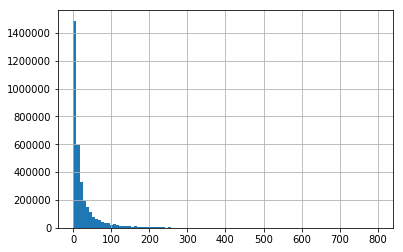

In [66]:
promos5.PROMOTIONS_AVAILABLE.hist(bins = 100)

In [88]:
#promos5.to_parquet('/main/data/MVideo_2/prom_temp.parquet')

In [64]:
#promos5 = pd.read_parquet('/main/data/MVideo_2/prom_temp.parquet')

In [90]:
week8 = week7.copy()

In [91]:
for i in range(9):
    tpromos = promos5.copy()
    tpromos.DATE += pd.Timedelta(str(7 * i) + ' days')
    tpromos.rename(columns = {'PROMOTIONS_AVAILABLE': 'PROMOTIONS_AVAILABLE_W' + str(i)}, inplace = True)
    week8 = pd.merge(week8, tpromos, how = 'left')
    print(i)

0
1
2
3
4
5
6
7
8


In [92]:
tpromos = promos5.copy()
tpromos.DATE -= pd.Timedelta('7 days')
tpromos.rename(columns = {'PROMOTIONS_AVAILABLE': 'PROMOTIONS_AVAILABLE_P1'}, inplace = True)
week8 = pd.merge(week8, tpromos, how = 'left')

In [94]:
week8.fillna(0, inplace = True)

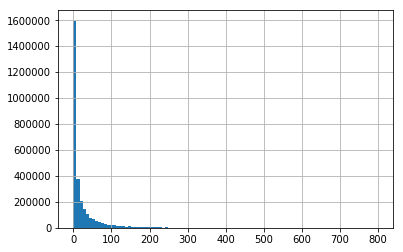

In [95]:
week8.PROMOTIONS_AVAILABLE_W0.hist(bins = 100)

In [96]:
li = {}
for i in range(3):
    li[i] = []
for i in range(8):
    li[0].append('PROMOTIONS_AVAILABLE_DIFF_W' + str(i))
    li[1].append('PROMOTIONS_AVAILABLE_W' + str(i))
    li[2].append('PROMOTIONS_AVAILABLE_W' + str(i + 1))
tpromos = pd.DataFrame(data = week8[li[1]].values - week8[li[2]].values, index = week8.index, columns = li[0])

In [97]:
week8 = week8.join(tpromos)

In [98]:
week8[li[0]] = week8[li[0]].apply(np.abs)

In [99]:
tpromos = week8[li[0]]
week8['PROMOTIONS_AVAILABLE_ABS_DIFF_MEAN_8'] = tpromos.mean(axis = 1)

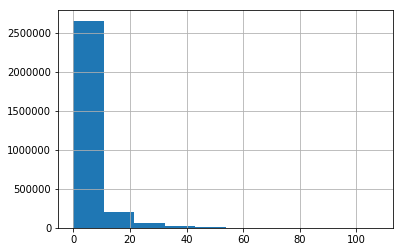

In [100]:
week8.PROMOTIONS_AVAILABLE_ABS_DIFF_MEAN_8.hist()

In [101]:
week8.drop(columns = li[0], inplace = True)

In [103]:
week8['PROMOTIONS_AVAILABLE_DIFF_P1'] = week8.PROMOTIONS_AVAILABLE_P1 - week8.PROMOTIONS_AVAILABLE_W0

In [104]:
week8.head()

,STORE_ID,PRODUCT_ID,DATE,MAINCATEGORY_ID,SUBCATEGORY_ID,REGULAR_SALES_PRICE_INCL_TAX,REGION,INTERNET,PROMOTIONS_AVAILABLE_W0,PROMOTIONS_AVAILABLE_W1,PROMOTIONS_AVAILABLE_W2,PROMOTIONS_AVAILABLE_W3,PROMOTIONS_AVAILABLE_W4,PROMOTIONS_AVAILABLE_W5,PROMOTIONS_AVAILABLE_W6,PROMOTIONS_AVAILABLE_W7,PROMOTIONS_AVAILABLE_W8,PROMOTIONS_AVAILABLE_P1,PROMOTIONS_AVAILABLE_ABS_DIFF_MEAN_8,PROMOTIONS_AVAILABLE_DIFF_P1
0,S011,10007755,2016-08-14,107,302,6990,77,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,S011,10007755,2016-08-21,107,302,6990,77,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,S011,10007755,2016-08-28,107,302,6990,77,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,S011,10007755,2016-09-04,107,302,6990,77,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,S011,10007755,2016-09-11,107,302,6990,77,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
week8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935729 entries, 0 to 2935728
Data columns (total 20 columns):
STORE_ID                                object
PRODUCT_ID                              int64
DATE                                    datetime64[ns]
MAINCATEGORY_ID                         int64
SUBCATEGORY_ID                          int64
REGULAR_SALES_PRICE_INCL_TAX            int64
REGION                                  int64
INTERNET                                int64
PROMOTIONS_AVAILABLE_W0                 float64
PROMOTIONS_AVAILABLE_W1                 float64
PROMOTIONS_AVAILABLE_W2                 float64
PROMOTIONS_AVAILABLE_W3                 float64
PROMOTIONS_AVAILABLE_W4                 float64
PROMOTIONS_AVAILABLE_W5                 float64
PROMOTIONS_AVAILABLE_W6                 float64
PROMOTIONS_AVAILABLE_W7                 float64
PROMOTIONS_AVAILABLE_W8                 float64
PROMOTIONS_AVAILABLE_P1                 float64
PROMOTIONS_AVAILABLE_ABS_DIFF

In [106]:
week8.to_parquet('/main/data/MVideo_2/week_ft_5.parquet')

In [3]:
holidays = pd.DataFrame({'DATE': pd.date_range(start = '2015-01-01', end = '2018-12-31')})

In [4]:
holidays['HOLIDAY'] = pd.Series(pd.date_range(start = '2015-01-01', end = '2018-12-31').dayofweek)

In [5]:
hol_dict = {0 : 0, 1 : 0, 2 : 0, 3 : 0, 4 : 0, 5 : 1, 6 : 1}

In [6]:
holidays.HOLIDAY = holidays.HOLIDAY.map(hol_dict)

In [7]:
extra_hol = [
            '2015-01-01','2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-02-23',
            '2015-03-09', '2015-05-01', '2015-05-04', '2015-05-11', '2015-06-12', '2015-11-04',
            '2016-01-01', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08', '2016-02-22', '2016-02-23',
            '2016-03-07', '2016-03-08', '2016-05-02', '2016-05-03', '2016-05-09', '2016-06-13', '2016-11-04',
            '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-02-23', '2017-02-24', '2017-03-08',
            '2017-05-01', '2017-05-08', '2017-05-09', '2017-06-12', '2017-11-06',
            '2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-08', '2018-02-23', '2018-03-08',
            '2018-03-09', '2018-04-30', '2018-05-01', '2018-05-02', '2018-05-09', '2018-06-11', '2018-06-12', '2018-11-05',
            '2018-12-31'
]

In [8]:
holidays.HOLIDAY.mask(holidays.DATE.isin(extra_hol), 1, inplace = True)

In [9]:
excess_hol = ['2016-02-20', '2018-04-28', '2018-06-09', '2018-12-29']

In [10]:
holidays.HOLIDAY.mask(holidays.DATE.isin(excess_hol), 0, inplace = True)

In [11]:
holidays.HOLIDAY = holidays.HOLIDAY.astype('bool')

In [12]:
hol_sp = pd.read_parquet('/main/data/MVideo_2/sp_holidays.parquet')

In [13]:
hol_sp.columns = ['YEAR', 'DATE', 'WDAY', 'HOLIDAY_NAME', 'HOLIDAY_TYPE']

In [14]:
hol_sp = hol_sp[hol_sp['HOLIDAY_TYPE'] != 'Season']

In [15]:
hol_sp.DATE.mask(hol_sp.DATE == 'Jan 14', 'Jan 13', inplace = True)

In [16]:
hol_sp['MONTH'] = hol_sp.DATE.str[0:3]

In [17]:
m_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
          'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [18]:
hol_sp.MONTH = hol_sp.MONTH.map(m_dict)

In [19]:
hol_sp['DAY'] = hol_sp.DATE.str[-2:]

In [20]:
hol_sp.DATE = pd.to_datetime(hol_sp[['YEAR', 'MONTH', 'DAY']])

In [21]:
hol_sp['HOLIDAY_SP'] = 1

In [23]:
holidays = holidays.merge(hol_sp, how = 'left')

In [24]:
holidays = holidays[['DATE', 'HOLIDAY', 'HOLIDAY_SP']].copy()

In [25]:
holidays.fillna(0, inplace = True)

In [26]:
holidays.HOLIDAY_SP = holidays.HOLIDAY_SP.astype('bool')

In [27]:
holidays.drop_duplicates(inplace = True)

In [28]:
holidays

,DATE,HOLIDAY,HOLIDAY_SP
0,2015-01-01,True,True
1,2015-01-02,True,True
2,2015-01-03,True,True
3,2015-01-04,True,True
4,2015-01-05,True,True
5,2015-01-06,True,True
6,2015-01-07,True,True
7,2015-01-08,True,True
8,2015-01-09,True,True
9,2015-01-10,True,False


In [29]:
holidays['HOLIDAY_P'] = holidays.HOLIDAY.shift(-7)

In [30]:
holidays['HOLIDAY_SP_P'] = holidays.HOLIDAY_SP.shift(-7)

In [31]:
holidays = holidays.iloc[:-7, :].copy()

In [32]:
holidays[['HOLIDAY_P', 'HOLIDAY_SP_P']] = holidays[['HOLIDAY_P', 'HOLIDAY_SP_P']].astype('bool')

In [33]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 0 to 1454
Data columns (total 5 columns):
DATE            1454 non-null datetime64[ns]
HOLIDAY         1454 non-null bool
HOLIDAY_SP      1454 non-null bool
HOLIDAY_P       1454 non-null bool
HOLIDAY_SP_P    1454 non-null bool
dtypes: bool(4), datetime64[ns](1)
memory usage: 28.4 KB


In [34]:
holidays

,DATE,HOLIDAY,HOLIDAY_SP,HOLIDAY_P,HOLIDAY_SP_P
0,2015-01-01,True,True,True,True
1,2015-01-02,True,True,True,True
2,2015-01-03,True,True,True,False
3,2015-01-04,True,True,True,False
4,2015-01-05,True,True,False,False
5,2015-01-06,True,True,False,True
6,2015-01-07,True,True,False,False
7,2015-01-08,True,True,False,False
8,2015-01-09,True,True,False,False
9,2015-01-10,True,False,True,False


In [35]:
holidays.to_parquet('/main/data/MVideo_2/hol_ft_5.parquet')